In [4]:
import os
import logging
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import DebertaTokenizer, DebertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Constants and configurations
DATA_FILE = "test_data.csv"
SAMPLE_SIZE = 20  # Set to None to use all data, or an integer to sample
MODEL_NAME = 'microsoft/deberta-base'
OUTPUT_DIR = './results'
LOGGING_DIR = './logs'
TRAINED_MODEL_DIR = './trained_model'

# Ensure output directories exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LOGGING_DIR, exist_ok=True)
os.makedirs(TRAINED_MODEL_DIR, exist_ok=True)

# Load the tokenizer and model
logging.info("Loading tokenizer and model...")
tokenizer = DebertaTokenizer.from_pretrained(MODEL_NAME)
model = DebertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Load and preprocess the dataset
if not os.path.exists(DATA_FILE):
    logging.error(f"Data file {DATA_FILE} not found.")
    raise FileNotFoundError(f"Data file {DATA_FILE} not found.")
else:
    logging.info(f"Loading data from {DATA_FILE}...")
    df = pd.read_csv(DATA_FILE)

# Drop unnecessary columns
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# Rename columns
rename_dict = {
    "abstract.text_sw": "abstract",
    "biblio.invention_title.text_sw": "title",
    "claims.claims_sw": "claims"
}
df.rename(columns=rename_dict, inplace=True)

# Check for necessary columns
required_columns = ['title', 'abstract', 'claims', 'yo2']
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    logging.error(f"Missing columns in the dataset: {missing_columns}")
    raise KeyError(f"Missing columns in the dataset: {missing_columns}")

# Combine text columns into 'full_text'
logging.info("Combining text columns into 'full_text'...")
df['full_text'] = df['title'] + ' ' + df['abstract'] + ' ' + df['claims']

# Sample data if SAMPLE_SIZE is specified
if SAMPLE_SIZE:
    df = df.sample(SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    logging.info(f"Sampled {SAMPLE_SIZE} entries from the dataset.")
else:
    logging.info("Using all data in the dataset.")

# Split the data
logging.info("Splitting data into training and testing sets...")
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['full_text'].tolist(),
    df['yo2'].tolist(),
    test_size=0.2,
    random_state=42
)

# Tokenization function
def tokenize_function(texts):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )

# Tokenize the data
logging.info("Tokenizing training data...")
train_inputs = tokenize_function(train_texts)
logging.info("Tokenizing testing data...")
test_inputs = tokenize_function(test_texts)

# Create datasets
logging.info("Creating training and testing datasets...")
train_dataset = Dataset.from_dict({
    'input_ids': train_inputs['input_ids'],
    'attention_mask': train_inputs['attention_mask'],
    'labels': torch.tensor(train_labels)
})
test_dataset = Dataset.from_dict({
    'input_ids': test_inputs['input_ids'],
    'attention_mask': test_inputs['attention_mask'],
    'labels': torch.tensor(test_labels)
})

# Training arguments
logging.info("Setting up training arguments...")
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=LOGGING_DIR,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    no_cuda=not torch.cuda.is_available(),
    logging_steps=10,
    logging_first_step=True
)

if torch.cuda.is_available():
    logging.info("CUDA is available. Training on GPU.")
    device = torch.device('cuda')
else:
    logging.info("CUDA is not available. Training on CPU.")
    device = torch.device('cpu')

model.to(device)

# Metrics computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    labels = torch.tensor(labels)
    acc = accuracy_score(labels.cpu(), predictions.cpu())
    precision, recall, f1, _ = precision_recall_fscore_support(labels.cpu(), predictions.cpu(), average='binary')
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}

# Initialize the Trainer
logging.info("Initializing the Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

# Train the model
try:
    logging.info("Starting training...")
    trainer.train()
    logging.info("Training completed successfully.")
except Exception as e:
    logging.error(f"An error occurred during training: {e}")
    raise e

# Save the model
logging.info(f"Saving the model to {TRAINED_MODEL_DIR}...")
trainer.save_model(TRAINED_MODEL_DIR)

# Prediction function
def predict(texts):
    if isinstance(texts, str):
        texts = [texts]
    logging.info(f"Predicting labels for {len(texts)} texts...")
    inputs = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=-1)
    return predictions.cpu().numpy()

# Evaluate the model on the test set
logging.info("Evaluating the model on the test set...")
metrics = trainer.evaluate(eval_dataset=test_dataset)
logging.info(f"Test set metrics: {metrics}")

# Example prediction for a single patent
example_patent = df['full_text'].iloc[0]
prediction = predict(example_patent)
logging.info(f'Prediction for the example patent: {prediction}')

# Predict on all data
logging.info("Predicting on all data...")
df['predicted_yo2'] = predict(df['full_text'].tolist())

# Display sample predictions
columns_to_view = ['title', 'abstract', 'claims', 'yo2', 'predicted_yo2']
logging.info("Displaying sample predictions:")
(df[columns_to_view].head())


/Users/meg.patakota/Library/Caches/pypoetry/virtualenvs/climate-patent-project-96j3MAcc-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-23 17:23:52,704 - INFO - Loading tokenizer and model...
/Users/meg.patakota/Library/Caches/pypoetry/virtualenvs/climate-patent-project-96j3MAcc-py3.12/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


KeyboardInterrupt: 

# plot results

In [6]:
# prediction library imports
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

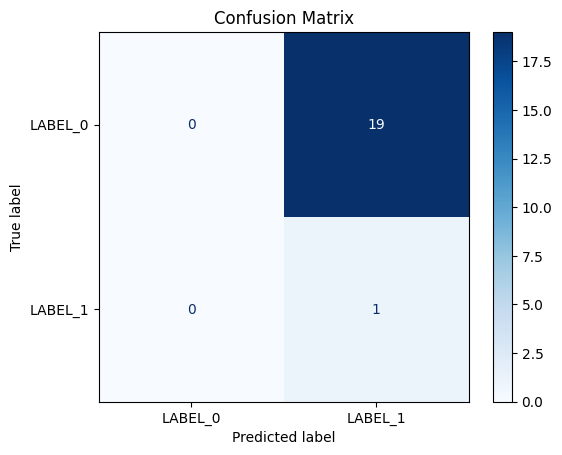

Classification Report:
               precision    recall  f1-score   support

     LABEL_0       0.00      0.00      0.00        19
     LABEL_1       0.05      1.00      0.10         1

    accuracy                           0.05        20
   macro avg       0.03      0.50      0.05        20
weighted avg       0.00      0.05      0.00        20



/Users/meg.patakota/Library/Caches/pypoetry/virtualenvs/climate-patent-project-96j3MAcc-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/meg.patakota/Library/Caches/pypoetry/virtualenvs/climate-patent-project-96j3MAcc-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/meg.patakota/Library/Caches/pypoetry/virtualenvs/climate-patent-project-96j3MAcc-py3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision

In [4]:
# Get true labels and predictions
true_labels = df['yo2']
predicted_labels = df['predicted_yo2']

# A confusion matrix provides a summary of prediction results on a classification problem. It shows the number of correct and incorrect predictions broken down by each class.
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.config.id2label.values())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# A classification report provides precision, recall, F1-score, and support for each class.
report = classification_report(true_labels, predicted_labels, target_names=model.config.id2label.values())
print("Classification Report:\n", report)


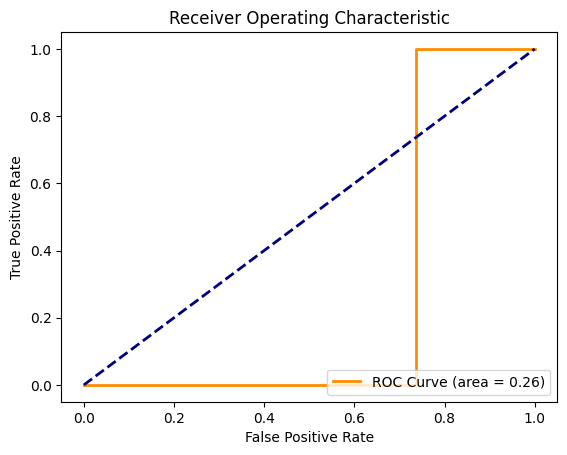

In [5]:
# The ROC curve plots the true positive rate against the false positive rate at various threshold settings. The AUC score summarizes the ROC curve.
# Assuming binary classification and that you have access to the probabilities
# Get model predictions probabilities
def predict_proba(texts):
    if isinstance(texts, str):
        texts = [texts]
    inputs = tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
    return probs[:, 1].cpu().numpy()  # Probability of the positive class

# Get probabilities for all data
df['predicted_proba'] = predict_proba(df['full_text'].tolist())

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels, df['predicted_proba'])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:0.2f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


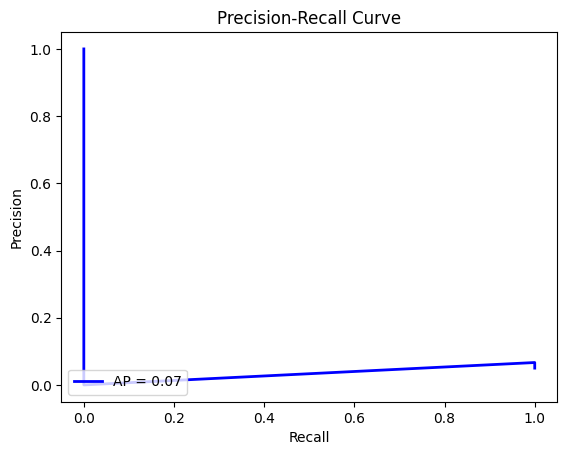

In [7]:
# Useful for imbalanced datasets.
precision, recall, thresholds = precision_recall_curve(true_labels, df['predicted_proba'])
average_precision = average_precision_score(true_labels, df['predicted_proba'])

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label=f'AP = {average_precision:0.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()
